In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GroupShuffleSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import optuna
import joblib
import numpy as np
from sklearn.model_selection import KFold
import cudf
import cupy as cp
warnings.filterwarnings("ignore")

2025-12-11 06:38:28.551999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765435109.063360      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765435109.192317      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)
    
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")
    
    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")
            
            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
            
            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")
            
        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")
    
    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")
    
    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")
    
    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)
    
    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])
    
    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])
    
    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")
    
    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")
    
    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")
    
    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")
    
    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")
    
    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }
    
    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)
    
    plt.suptitle(f'{split_name} Set - Prediction Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")
    
    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")
    
    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height_vectorized(df):
    """
    Convierte player_height de formato '6-2' a pulgadas.
    Rellena NaNs con la mediana.
    """
    # Separar pies y pulgadas
    split_height = df['player_height'].str.split('-', expand=True)
    
    # Convertir a float
    feet = split_height[0].astype('float32')
    inches = split_height[1].astype('float32')
    
    # Calcular altura en pulgadas
    height_inches = feet * 12 + inches
    
    # Rellenar NaNs con la mediana
    height_inches = height_inches.fillna(height_inches.median())
    
    # Guardar en el DataFrame
    df['height_inches'] = height_inches
    
    return df

def calculate_age_vectorized(df, reference_date='2023-09-01'):
    """
    Calcula la edad en años usando solo operaciones GPU (cuDF/cuPy) sin convertir a pandas.
    reference_date debe estar en formato 'YYYY-MM-DD'.
    """
    # Extraer año, mes y día de la fecha de nacimiento como strings y convertir a int
    birth_year = df['player_birth_date'].str.slice(0, 4).astype('int32')
    birth_month = df['player_birth_date'].str.slice(5, 7).astype('int32')
    birth_day = df['player_birth_date'].str.slice(8, 10).astype('int32')
    
    # Fecha de referencia
    ref_year, ref_month, ref_day = map(int, reference_date.split('-'))
    
    # Edad aproximada en años
    df['player_age'] = (ref_year - birth_year) + ((ref_month - birth_month)/12) + ((ref_day - birth_day)/365)
    
    # Rellenar valores faltantes con 0
    df['player_age'] = df['player_age'].fillna(0)
    
    return df


def calculate_bmi_vectorized(df):
    """
    Calcula BMI = (weight * 703) / height^2
    Rellena NaNs con la mediana.
    """
    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    
    return df

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')
    
    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")
    
    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()
    
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
    
    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

import cudf
import cupy as cp
import numpy as np

import pandas as pd
import numpy as np

def engineer_features_cpu(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING (CPU)")
    print("="*80)
    
    # Convertir a pandas si no lo es
    df = df.copy() if isinstance(df, pd.DataFrame) else pd.DataFrame(df)
    
    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    
    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))
    
    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt((df['x'] - df['ball_land_x'])**2 + (df['y'] - df['ball_land_y'])**2)
        df['angle_to_ball'] = np.arctan2(df['ball_land_y'] - df['y'], df['ball_land_x'] - df['x'])
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0
    
    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']
    
    print("✓ Processing player attributes (CPU)")
    # Estas funciones deben tener versiones CPU equivalentes
    df = parse_height_vectorized(df)
    df = calculate_age_vectorized(df)
    df = calculate_bmi_vectorized(df)
    
    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    group_cols = ['game_id', 'play_id', 'nfl_id']
    
    for lag in [1,2,3]:
        for col in ['x','y','s','a','vx','vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff().fillna(0)
    
    # Ajustar dirección para mantener rango [-180, 180]
    dir_change = df['dir_change'].to_numpy()
    dir_change = np.where(dir_change > 180, dir_change - 360,
                     np.where(dir_change < -180, dir_change + 360, dir_change))
    df['dir_change'] = dir_change
    
    print("✓ Computing rolling statistics (window=3)")
    for col in ['s','a']:
        roll_mean = df.groupby(group_cols)[col].rolling(window=3, min_periods=1).mean().reset_index(level=[0,1,2], drop=True)
        roll_std  = df.groupby(group_cols)[col].rolling(window=3, min_periods=1).std().reset_index(level=[0,1,2], drop=True)
        df[f'{col}_roll_mean'] = roll_mean
        df[f'{col}_roll_std']  = roll_std
    
    # Fill NaNs
    df = df.fillna(0)
    
    print(f"\n📊 Features created: {len(df.columns)} total columns")
    return df



def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_side']
    
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences_gpu(df, sequence_length=10, for_training=True, chunk_size=5000):
    """
    Crear secuencias para LSTM totalmente en GPU usando cuDF y cupy,
    procesando por chunks para evitar MemoryError.
    """
    import cupy as cp
    import cudf

    print("\n" + "="*80)
    print("CREATING SEQUENCES (GPU, CHUNKED)")
    print("="*80)
    
    # Columnas dinámicas
    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]
    
    # Columnas estáticas adaptadas a tu dataset (one-hot)
    position_cols = [c for c in df.columns if c.startswith('player_position_')]
    role_cols = [c for c in df.columns if c.startswith('player_role_')]
    
    static_features = position_cols + role_cols + [
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball', 'player_side'
    ]
    
    sequences_list = []
    static_list = []
    targets_list = []
    metadata_list = []

    # Ordenar por agrupamiento y frame_id
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    # Obtener todos los grupos únicos
    group_keys = df[['game_id','play_id','nfl_id']].drop_duplicates()
    
    for start in range(0, len(group_keys), chunk_size):
        chunk_keys = group_keys.iloc[start:start+chunk_size]
        
        for idx in range(len(chunk_keys)):
            key = chunk_keys.iloc[idx]
            game_id, play_id, nfl_id = key['game_id'], key['play_id'], key['nfl_id']
            
            group = df[(df['game_id'] == game_id) & 
                       (df['play_id'] == play_id) & 
                       (df['nfl_id'] == nfl_id)]
            
            if for_training and not group['player_to_predict'].any():
                continue
            
            if len(group) < sequence_length:
                continue
            
            seq_data = group[sequence_features].tail(sequence_length).to_cupy()
            static_data = group[static_features].tail(1).to_cupy()
            
            sequences_list.append(seq_data)
            static_list.append(static_data)
            
            if for_training and 'ball_land_x' in group.columns:
                target = cp.array([[group['ball_land_x'].tail(1).values[0],
                                    group['ball_land_y'].tail(1).values[0]]], dtype=cp.float32)
                targets_list.append(target)
            
            metadata_list.append({
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': nfl_id,
                'num_frames_output': group['num_frames_output'].tail(1).values[0] if 'num_frames_output' in group.columns else 0,
                'last_x': group['x'].tail(1).values[0],
                'last_y': group['y'].tail(1).values[0],
            })
    
    # Convertir listas a arrays de cupy
    sequences = cp.stack(sequences_list).astype(cp.float32)
    static_data = cp.stack(static_list).astype(cp.float32)
    
    if for_training and len(targets_list) > 0:
        targets = cp.vstack(targets_list).astype(cp.float32)
    else:
        targets = None
    
    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")
    
    return sequences, static_data, targets, metadata_list


def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)
    
    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')
    
    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)
    
    combined = layers.concatenate([x, s])
    
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)
    
    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)
    
    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    model.summary()
    
    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)
    
    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }
    
    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        
        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65
        
        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })
    
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")
    
    return submission_df

In [4]:
import numpy as np #importar librerias básicas
import os

# fijar semilla para fines pedagógicos
np.random.seed(42)

#render de figs sobre notebook
%matplotlib inline
# para graficar
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#crear carpeta con resultados
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 1. Problema a resolver

**Objetivo:**  
Predecir las posiciones futuras (coordenadas `x`, `y`) de los jugadores en el campo durante una jugada de pase en la NFL, utilizando información de seguimiento (*tracking data*) antes del lanzamiento del balón.  

Este problema busca modelar el movimiento de los jugadores para mejorar la comprensión táctica del juego y apoyar estrategias de predicción espacial.

---

##  Entradas (Features)

Las variables de entrada corresponden a información de jugadas, jugadores y su dinámica en el campo antes del lanzamiento del balón:

| **Variable** | **Descripción** |
|:--------------|:----------------|
| `game_id` | Identificador único del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico, no único entre juegos). |
| `player_to_predict` | Indica si se evaluará la predicción de este jugador (`True`/`False`). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de cuadro (*frame*) dentro de la jugada, comienza en 1 para cada `game_id` y `play_id` (numérico). |
| `play_direction` | Dirección en la que avanza la ofensiva (`left` o `right`). |
| `absolute_yardline_number` | Distancia desde la zona de anotación del equipo en posesión (numérico). |
| `player_name` | Nombre del jugador (texto). |
| `player_height` | Altura del jugador en pies-pulgadas. |
| `player_weight` | Peso del jugador en libras (lbs). |
| `player_birth_date` | Fecha de nacimiento del jugador (`yyyy-mm-dd`). |
| `player_position` | Posición o rol típico del jugador en el campo (e.g., QB, WR, DB). |
| `player_side` | Equipo al que pertenece el jugador (`Offense` o `Defense`). |
| `player_role` | Rol específico en la jugada (`Passer`, `Targeted Receiver`, `Defensive Coverage`, `Other Route Runner`). |
| `x` | Posición del jugador a lo largo del eje longitudinal del campo (0–120 yardas). |
| `y` | Posición del jugador a lo largo del eje transversal del campo (0–53.3 yardas). |
| `s` | Velocidad instantánea del jugador (yardas/segundo). |
| `a` | Aceleración instantánea (yardas/segundo²). |
| `o` | Orientación corporal del jugador (en grados). |
| `dir` | Dirección del movimiento del jugador (en grados). |
| `num_frames_output` | Cantidad de cuadros a predecir para ese jugador (numérico). |
| `ball_land_x` | Posición en el eje longitudinal donde aterriza el balón (yardas). |
| `ball_land_y` | Posición en el eje transversal donde aterriza el balón (yardas). |

---

##  Salidas (Targets)

El conjunto de salida contiene las posiciones **predichas** de los jugadores **después** del lanzamiento del balón.

| **Variable** | **Descripción** |
|:--------------|:----------------|
| `game_id` | Identificador del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de *frame* en la secuencia posterior al lanzamiento (numérico). |
| `x` | **Posición predicha** del jugador a lo largo del eje longitudinal del campo (objetivo a predecir). |
| `y` | **Posición predicha** del jugador a lo largo del eje transversal del campo (objetivo a predecir). |



In [5]:
# Load data
train_df = load_training_data()
test_input_df, test_targets_df = load_test_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440

LOADING TEST DATA
✓ Test input: 49,753 rows
✓ Test targets: 5,837 predictions needed


# 2. **Obtener los Datos**

In [6]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


# 3. **Analisis Exploratorio**

In [7]:
train_df.info() #revisar cantidad de datos, tipos de datos, campos vacios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

### **conteo de los valores en las característica (object)**

In [8]:
import pandas as pd

# Identificar columnas categóricas (tipo object)
categorical_cols = train_df.select_dtypes(include='object').columns

# Mostrar el conteo de valores únicos de cada columna categórica
for col in categorical_cols:
    print(f"\n{'='*80}")
    print(f"Columna: {col}")
    print(f"{'='*80}")
    display(train_df[col].value_counts().to_frame(name='Conteo'))



Columna: play_direction


,Conteo
play_direction,
right,2459074
left,2421505



Columna: player_name


,Conteo
player_name,
Cameron Sutton,13641
Jared Goff,13517
Dak Prescott,13400
Darious Williams,13343
Patrick Mahomes,13299
...,...
Karl Brooks,17
Tae Davis,15
Thomas Incoom,15



Columna: player_height


,Conteo
player_height,
6-1,909987
6-0,810480
6-2,709743
5-11,552849
6-3,532059
6-4,376636
5-10,362030
6-5,220944
5-9,203225



Columna: player_birth_date


,Conteo
player_birth_date,
1993-01-22,24787
1996-05-21,23168
1999-10-06,23146
1996-05-16,21936
1999-04-19,21231
...,...
2000-03-06,18
1991-05-23,18
1996-07-20,17



Columna: player_position


,Conteo
player_position,
WR,1063660
CB,1056888
FS,476865
TE,417146
QB,401007
SS,392421
RB,314918
ILB,295593
OLB,207429



Columna: player_side


,Conteo
player_side,
Defense,2662657
Offense,2217922



Columna: player_role


,Conteo
player_role,
Defensive Coverage,2662657
Other Route Runner,1424243
Targeted Receiver,396914
Passer,396765


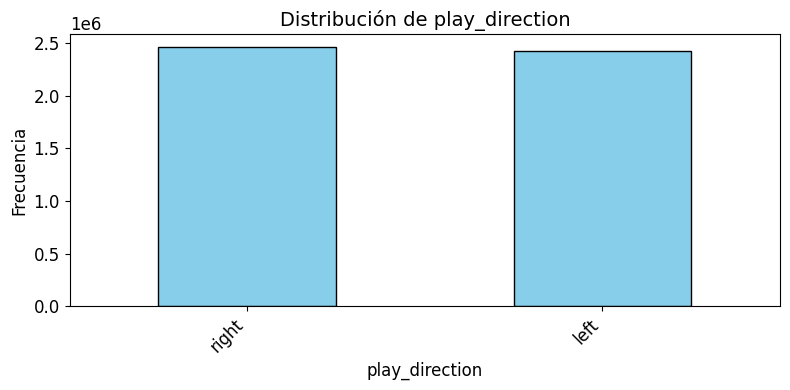

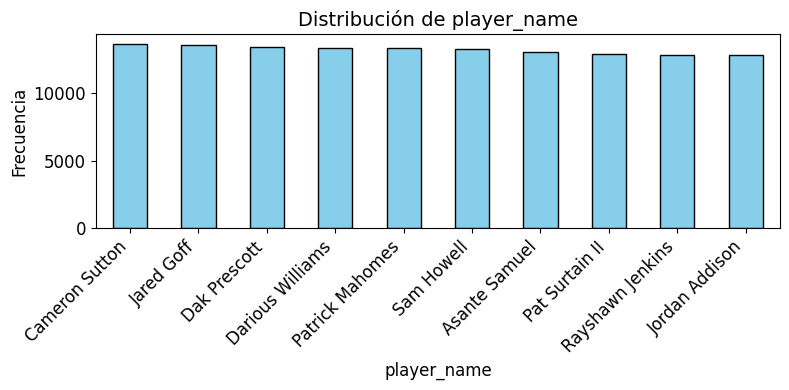

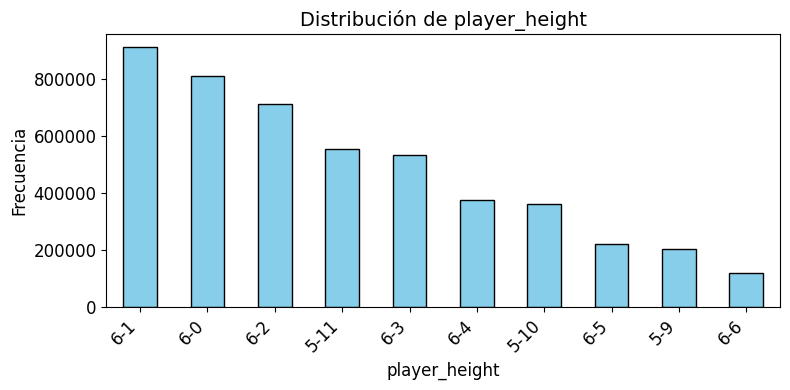

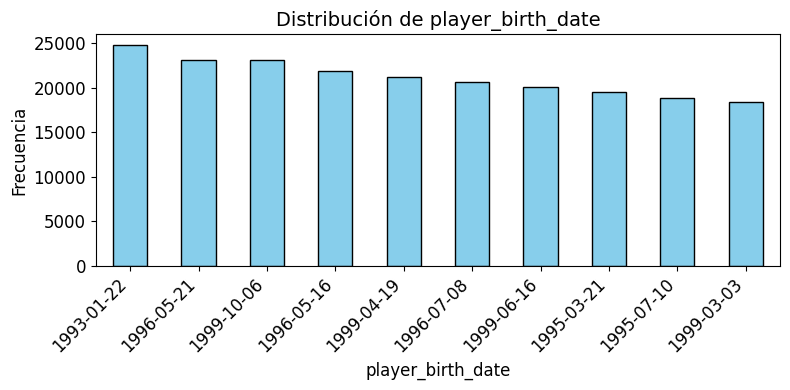

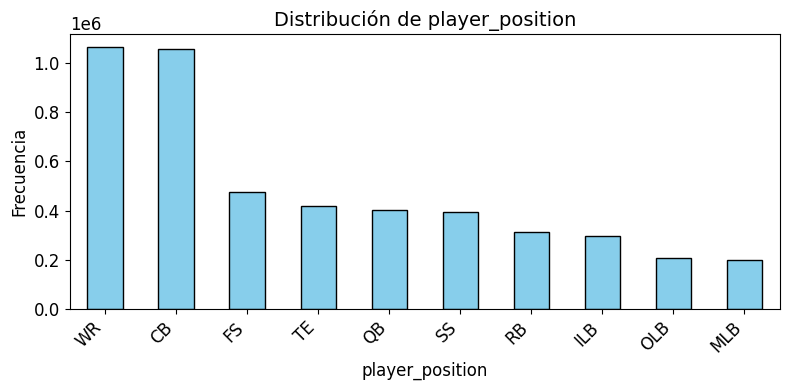

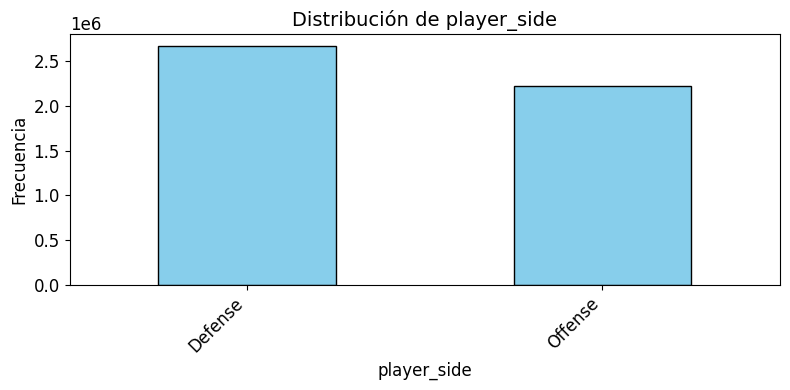

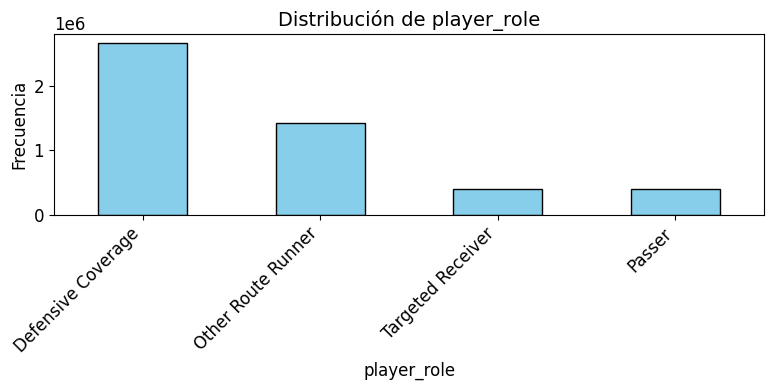

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Identificar las columnas categóricas
categorical_cols = train_df.select_dtypes(include='object').columns

# Crear una gráfica de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    # Mostrar solo las 10 categorías más frecuentes (para evitar saturar gráficos)
    train_df[col].value_counts().head(10).plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [10]:
# Mostrar estadísticas básicas de las variables numéricas
train_df.describe()


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [11]:
#valores nulos
train_df.isnull().sum()

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

In [12]:
# Número de valores únicos por columna
train_df.nunique().sort_values(ascending=False)

o                           36001
dir                         36001
x                           11872
ball_land_x                  7491
y                            5222
ball_land_y                  5030
play_id                      4317
nfl_id                       1384
player_name                  1383
player_birth_date            1132
a                            1105
s                            1033
game_id                       272
player_weight                 151
frame_id                      123
absolute_yardline_number       99
num_frames_output              34
player_position                19
player_height                  16
player_role                     4
player_to_predict               2
play_direction                  2
player_side                     2
dtype: int64

## **Histograma Variables Numericas**

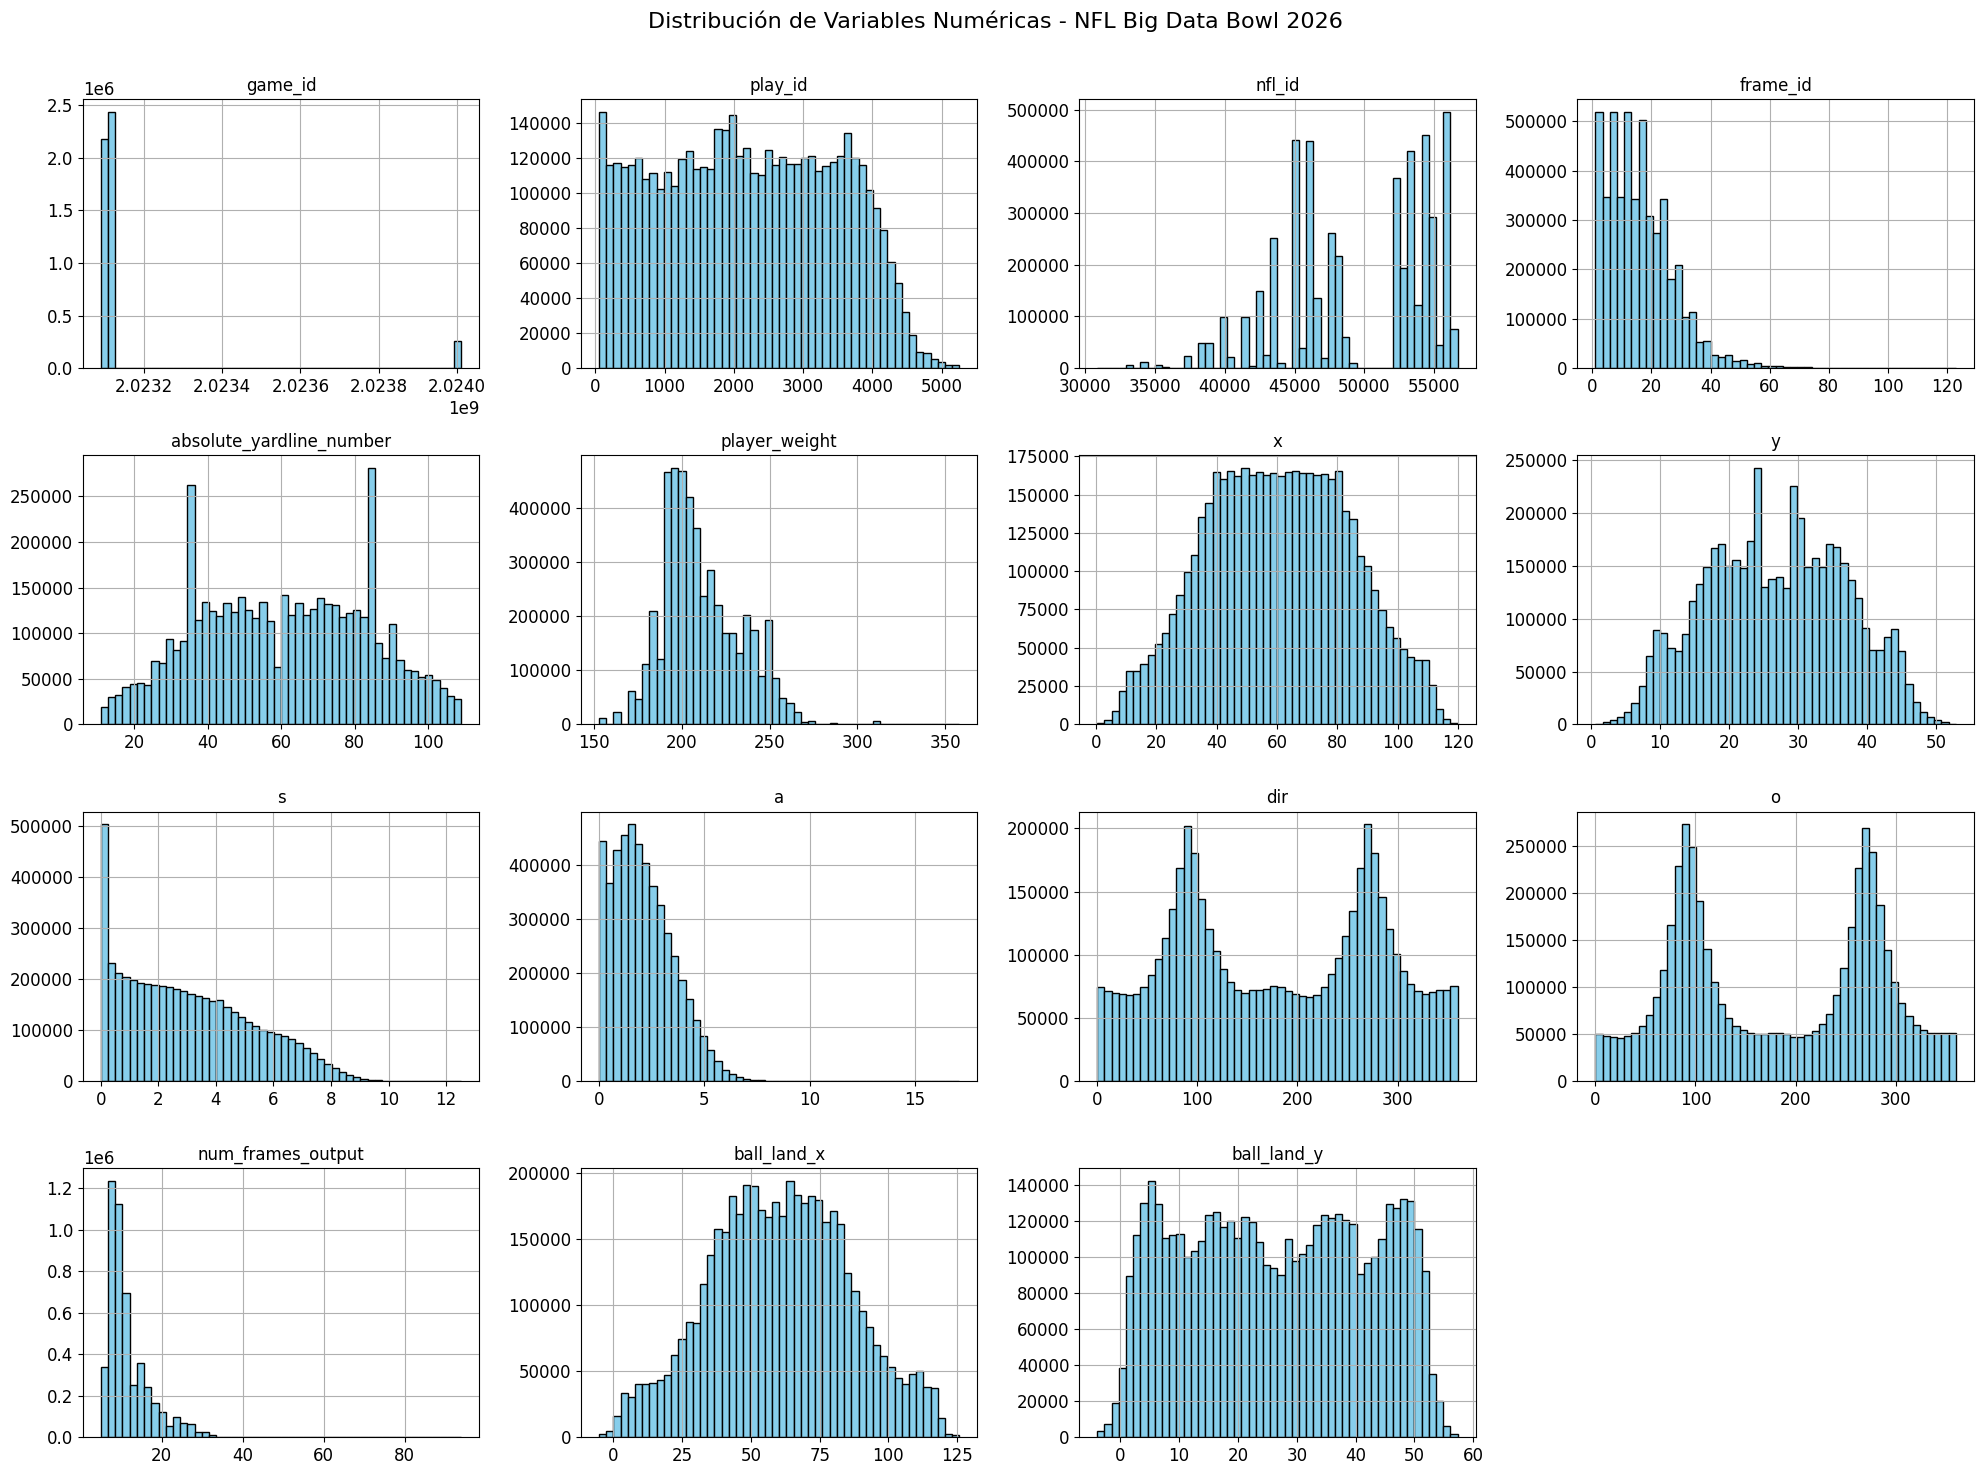

In [13]:
import matplotlib.pyplot as plt

# Crear histogramas de todas las variables numéricas del dataset NFL
train_df.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')

plt.suptitle("Distribución de Variables Numéricas - NFL Big Data Bowl 2026", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajustar para no tapar el título
plt.show()


## **Visualizacion de los Jugadores en el Campo**

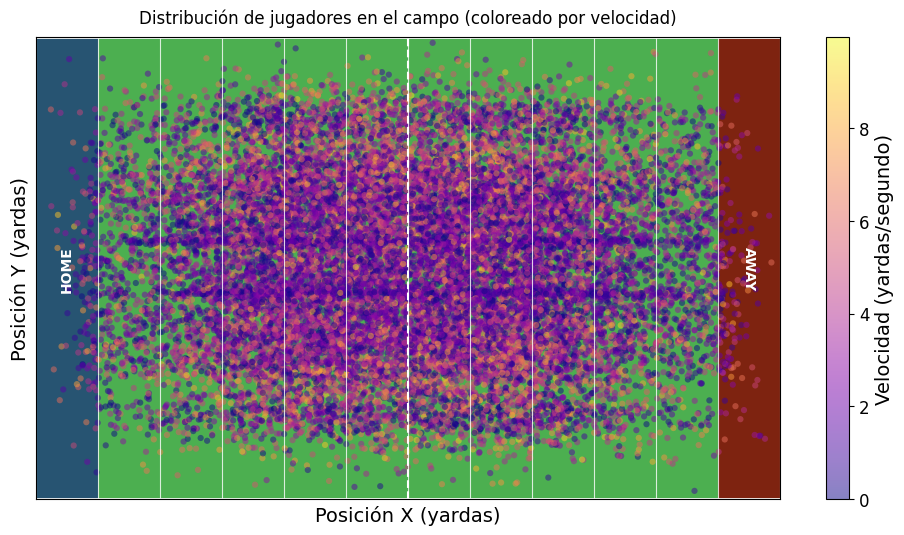

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ===========================================================
# 🏈 Función para graficar el campo (versión simplificada)
# ===========================================================
def draw_field(ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Límites del campo
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)

    # Fondo verde con degradado más claro
    ax.add_patch(Rectangle((0, 0), 120, 53.3, linewidth=0, facecolor='#4caf50', zorder=0))
    
    # End zones con color distinto (azul y rojo)
    ax.add_patch(Rectangle((0, 0), 10, 53.3, linewidth=0, facecolor='#1e3d7b', alpha=0.8))
    ax.add_patch(Rectangle((110, 0), 10, 53.3, linewidth=0, facecolor='#8b0000', alpha=0.8))

    # Líneas de 10 en 10 yardas
    for x in range(0, 121, 10):
        ax.plot([x, x], [0, 53.3], color='white', linewidth=0.8, alpha=0.8)

    # Línea central discontinua
    ax.plot([60, 60], [0, 53.3], color='white', linewidth=1.5, linestyle='--')

    # Bordes del campo
    ax.plot([0, 120], [0, 0], color='white', linewidth=2)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=2)

    # Textos en end zones
    ax.text(5, 26.65, 'HOME', color='white', fontsize=10, ha='center', va='center', rotation=90, fontweight='bold')
    ax.text(115, 26.65, 'AWAY', color='white', fontsize=10, ha='center', va='center', rotation=270, fontweight='bold')

    # Etiquetas
    ax.set_xlabel('Posición X (yardas)')
    ax.set_ylabel('Posición Y (yardas)')
    ax.set_title('Distribución de jugadores en el campo (coloreado por velocidad)', fontsize=12, pad=10)
    
    # Quitar bordes externos del gráfico
    ax.set_facecolor('#4caf50')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    return ax


# ===========================================================
# 📊 Gráfica de dispersión (posición vs velocidad)
# ===========================================================
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)

# Muestra aleatoria para visualización
subset = train_df.sample(20000, random_state=42)

# Graficar posiciones y colorear por velocidad
sc = ax.scatter(
    subset['x'], subset['y'],
    c=subset['s'], cmap='plasma', alpha=0.5, s=20, edgecolor='none'
)

# Barra de color (velocidad)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Velocidad (yardas/segundo)')

plt.show()


Mostrando jugada con play_id = 1154, número de jugadores: 918


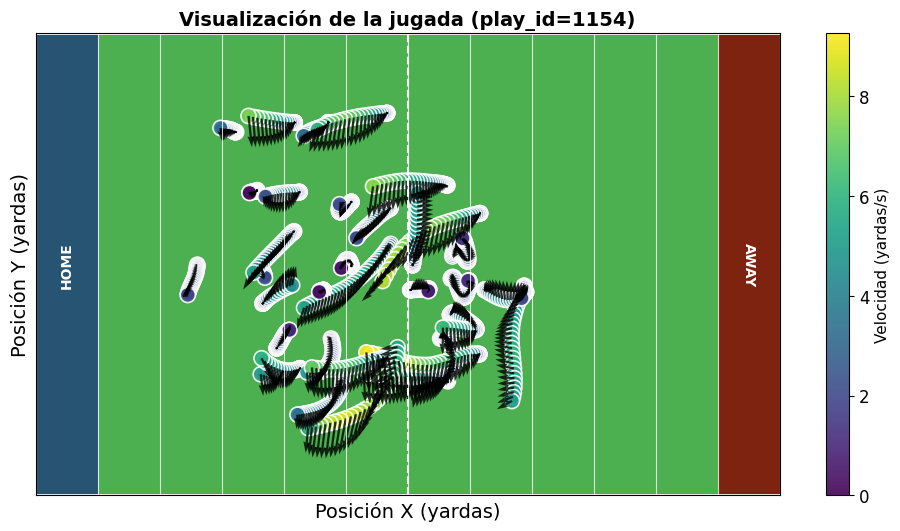

In [15]:
# ==========================================================
# VISUALIZAR JUGADA CON PARÁMETROS
# ==========================================================

# Seleccionar una jugada diferente (por ejemplo, la 5000ª en el dataset)
play_id = train_df['play_id'].iloc[5000]  
play_df = train_df[train_df['play_id'] == play_id]

print(f"Mostrando jugada con play_id = {play_id}, número de jugadores: {len(play_df)}")

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)  # función que dibuja el campo de juego

# Dibujar jugadores con un nuevo mapa de color (por ejemplo, "viridis")
sc = ax.scatter(
    play_df['x'], play_df['y'],
    c=play_df['s'], cmap='viridis', s=120, alpha=0.9, edgecolor='white', linewidth=1.2
)

# Calcular componentes de dirección
angles_rad = np.deg2rad(play_df['dir'])
u = np.cos(angles_rad) * play_df['s'] / 2
v = np.sin(angles_rad) * play_df['s'] / 2

# Dibujar direcciones (flechas)
ax.quiver(
    play_df['x'], play_df['y'],
    u, v,
    angles='xy', scale_units='xy', scale=1,
    color='black', width=0.003, alpha=0.8
)

# Barra de color
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Velocidad (yardas/s)", fontsize=11)

# Título más descriptivo
ax.set_title(f"Visualización de la jugada (play_id={play_id})", fontsize=14, weight='bold')

plt.show()


In [16]:
# ============================================
# MATRIZ DE CORRELACIÓN DEL CONJUNTO train_df
# ============================================

# Copiar el DataFrame original
train_df_num = train_df.copy()

# Eliminar columnas no numéricas (por ejemplo, variables categóricas como, 'playDirection', etc.)
train_df_num = train_df_num.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = train_df_num.corr()

# Mostrar la matriz con gradiente de color
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None)


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
game_id,1.000000,-0.046649,0.018240,-0.005799,0.006925,-0.005850,0.004195,0.002696,-0.003865,-0.000483,0.002208,0.002352,0.003425,-0.000923,0.007239
play_id,-0.046649,1.000000,0.016456,0.005741,-0.008377,-0.027185,-0.008586,-0.000180,-0.003735,-0.023165,0.000818,-0.000943,0.045453,-0.008406,-0.001256
nfl_id,0.018240,0.016456,1.000000,0.000521,-0.000295,-0.147903,0.000225,0.000361,0.035575,0.023728,-0.004477,-0.005935,0.000720,0.000538,0.000932
frame_id,-0.005799,0.005741,0.000521,1.000000,0.005030,0.004452,0.006850,0.002267,0.556111,0.210484,-0.002570,-0.002717,0.080511,0.006660,0.003080
absolute_yardline_number,0.006925,-0.008377,-0.000295,0.005030,1.000000,0.003593,0.937889,-0.004579,-0.000619,0.001649,0.092848,-0.004493,-0.011060,0.841294,-0.000779
player_weight,-0.005850,-0.027185,-0.147903,0.004452,0.003593,1.000000,0.003312,0.002333,-0.080487,0.014764,0.002948,0.008709,-0.013794,0.003559,0.003507
x,0.004195,-0.008586,0.000225,0.006850,0.937889,0.003312,1.000000,-0.005442,-0.002098,0.001613,-0.066573,0.131395,-0.012528,0.859600,-0.009878
y,0.002696,-0.000180,0.000361,0.002267,-0.004579,0.002333,-0.005442,1.000000,-0.002318,-0.001657,-0.000736,0.006594,0.000495,-0.004685,0.050480
s,-0.003865,-0.003735,0.035575,0.556111,-0.000619,-0.080487,-0.002098,-0.002318,1.000000,0.212926,0.002747,-0.018597,0.053797,-0.002347,-0.001241
a,-0.000483,-0.023165,0.023728,0.210484,0.001649,0.014764,0.001613,-0.001657,0.212926,1.000000,-0.002907,-0.007024,0.007182,0.001751,0.000826


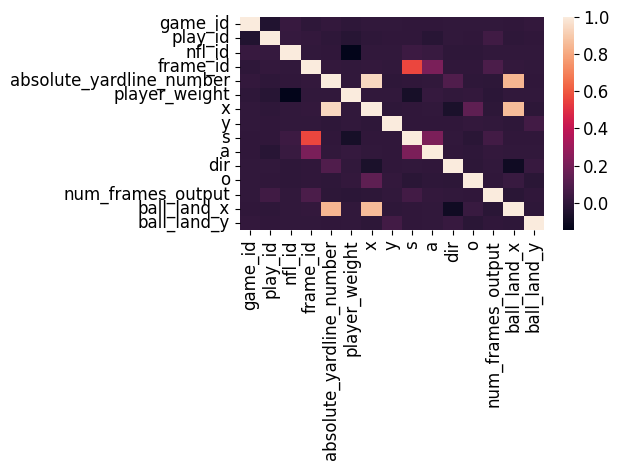

In [17]:
### ============================================================
#  MATRIZ DE CORRELACIÓN (VISUALIZACIÓN) - NFL Big Data Bowl 2026
# ============================================================

import seaborn as sns  # librería útil para graficar mapas de calor
import matplotlib.pyplot as plt

sns.heatmap(
    corr_matrix,
    xticklabels=corr_matrix.columns.values,
    yticklabels=corr_matrix.columns.values
)

plt.tight_layout()
plt.savefig('/kaggle/working/nfl_corr_matrix.pdf', format='pdf', dpi=300)
plt.show()


In [18]:
# ============================================================
#  CORRELACIÓN CON VARIABLES OBJETIVO (x, y) - NFL Big Data Bowl 2026
# ============================================================

# Correlación de todas las variables con la coordenada 'x'
print("🔹 Correlaciones con la variable objetivo 'x':\n")
print(corr_matrix["x"].sort_values(ascending=False))

print("\n🔹 Correlaciones con la variable objetivo 'y':\n")
print(corr_matrix["y"].sort_values(ascending=False))


🔹 Correlaciones con la variable objetivo 'x':

x                           1.000000
absolute_yardline_number    0.937889
ball_land_x                 0.859600
o                           0.131395
frame_id                    0.006850
game_id                     0.004195
player_weight               0.003312
a                           0.001613
nfl_id                      0.000225
s                          -0.002098
y                          -0.005442
play_id                    -0.008586
ball_land_y                -0.009878
num_frames_output          -0.012528
dir                        -0.066573
Name: x, dtype: float64

🔹 Correlaciones con la variable objetivo 'y':

y                           1.000000
ball_land_y                 0.050480
o                           0.006594
game_id                     0.002696
player_weight               0.002333
frame_id                    0.002267
num_frames_output           0.000495
nfl_id                      0.000361
play_id                    -0.

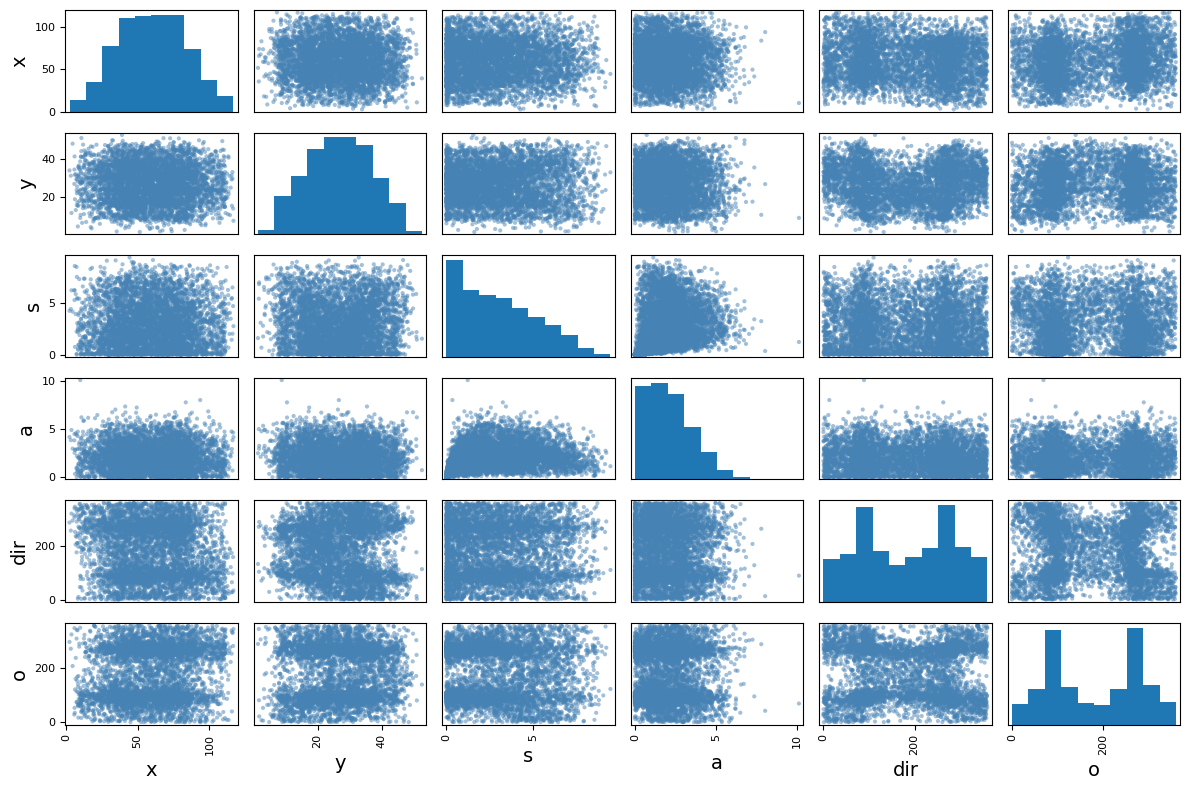

In [19]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import os

# Crear carpeta para guardar resultados
os.makedirs('results', exist_ok=True)

# Seleccionar una muestra pequeña del dataset
sample_df = train_df.sample(5000, random_state=42)   # puedes ajustar

# Selección de variables de interés
attributes = ["x", "y", "s", "a", "dir", "o"]

# Crear la scatter matrix
scatter_matrix(sample_df[attributes], figsize=(12, 8), alpha=0.5, diagonal='hist', color='steelblue')

# Ajustar layout para evitar superposición
plt.tight_layout()

# Guardar como imagen (recomendado) o PDF
plt.savefig('results/scatter_matrix_plot.png', dpi=150)  # PNG es más ligero que PDF
# plt.savefig('results/scatter_matrix_plot.pdf', format='pdf', dpi=300)  # opcional

# Mostrar gráfico
plt.show()


# **4. Preparar los datos para los algoritmos de aprendizaje de máquina**

In [20]:
# Crear una copia del DataFrame original
df_copy = train_df.copy()

In [21]:
#valores nulos
df_copy.isnull().sum()

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

In [22]:
# Duplicados
duplicados = df_copy.duplicated().sum()
print(f'Duplicados encontrados: {duplicados}')

Duplicados encontrados: 0


###  Normalización de la dirección de la jugada

####  Objetivo
El objetivo de esta práctica es **unificar la orientación espacial de todas las jugadas** en el dataset de la NFL.  
Algunas jugadas avanzan hacia la derecha y otras hacia la izquierda, lo que genera inconsistencias en las coordenadas y en las direcciones de movimiento.  
Normalizar la dirección permite que **todas las jugadas se representen en un mismo sentido del campo**, facilitando el análisis y la comparación entre ellas.

####  Qué se modifica
- Se invierten las coordenadas espaciales:
  - `x → 120 - x`
  - `y → 53.3 - y`
- Se ajustan los ángulos de dirección y orientación:
  - `dir` y `o` se rotan **180° (mod 360)** para mantener la coherencia en el sentido del movimiento.
- Si existen coordenadas relacionadas con la posición del balón (`ball_land_x`, `ball_land_y`), también se reflejan.

####  Beneficios
- Garantiza **coherencia espacial** en todas las jugadas.
- Facilita el **análisis exploratorio y la visualización** de trayectorias.
- Evita que el modelo de machine learning aprenda diferencias irrelevantes causadas por la dirección de la jugada.
- Mejora la **calidad y consistencia** de las características utilizadas en el entrenamiento.


In [23]:
# Normalizar la dirección de las jugadas en el DataFrame
df_copy = normalize_play_direction(df_copy)

   Normalized 2,421,505 plays moving left → right


### Codificación combinada de variables categóricas

En este paso se aplican dos tipos de codificación:

- **Label Encoding** a `player_position` y `player_side`, ya que son variables con pocas categorías y pueden representarse como enteros sin afectar el aprendizaje.
- **One-Hot Encoding** a `player_role`, dado que representa distintos roles sin relación ordinal entre ellos (bloquear, recibir, correr, etc.).  
  Este método expande las características del dataset, creando una columna binaria (0/1) por cada tipo de rol, lo que permite al modelo distinguir mejor entre ellos.


#### Ventajas
- Permite que las variables categóricas sean interpretadas numéricamente por el modelo.  
- Mejora la **consistencia de los datos** y evita errores durante el entrenamiento.  
- Preserva la información semántica de las categorías sin aumentar dimensionalidad.


In [24]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# ----------------------------------------------------
# Paso 1: Label Encoding solo a player_side
# ----------------------------------------------------
df_encoded, encoders = encode_categorical(df_copy) 

# ----------------------------------------------------
# Paso 2: One-Hot Encoding a player_position y player_role
# ----------------------------------------------------
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Seleccionamos las columnas a codificar
cols_to_onehot = ['player_position', 'player_role']
one_hot_array = one_hot_encoder.fit_transform(df_encoded[cols_to_onehot])

# Creamos DataFrame con nombres de columnas generadas
one_hot_cols = one_hot_encoder.get_feature_names_out(cols_to_onehot)
one_hot_df = pd.DataFrame(one_hot_array, columns=one_hot_cols, index=df_encoded.index)

# Concatenamos al dataset y eliminamos columnas originales
df_encoded = pd.concat([df_encoded.drop(cols_to_onehot, axis=1), one_hot_df], axis=1)

# Verificamos las nuevas columnas
print("Nuevas columnas generadas por One Hot Encoding:")
print(one_hot_cols)
df_encoded.head()


Nuevas columnas generadas por One Hot Encoding:
['player_position_CB' 'player_position_DE' 'player_position_DT'
 'player_position_FB' 'player_position_FS' 'player_position_ILB'
 'player_position_K' 'player_position_LB' 'player_position_MLB'
 'player_position_NT' 'player_position_OLB' 'player_position_P'
 'player_position_QB' 'player_position_RB' 'player_position_S'
 'player_position_SS' 'player_position_T' 'player_position_TE'
 'player_position_WR' 'player_role_Defensive Coverage'
 'player_role_Other Route Runner' 'player_role_Passer'
 'player_role_Targeted Receiver']


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_position_RB,player_position_S,player_position_SS,player_position_T,player_position_TE,player_position_WR,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


###  Ingeniería de características

En esta etapa se crean nuevas features derivadas a partir de los datos originales para mejorar el desempeño de los modelos de Machine Learning.  

####  Features de movimiento
- `vx`, `vy`: Componentes X e Y de la velocidad del jugador.
- `ox`, `oy`: Componentes X e Y de la orientación del jugador.

####  Features relacionadas con el balón
- `dist_to_ball`: Distancia del jugador al balón.
- `angle_to_ball`: Ángulo relativo al balón.
- `vel_toward_ball`: Componente de la velocidad hacia el balón.

####  Features espaciales en el campo
- `dist_to_left_sideline`, `dist_to_right_sideline`, `dist_to_nearest_sideline`: Distancias a las líneas laterales.
- `dist_to_endzone`: Distancia al endzone contrario.

####  Features de atributos del jugador
- `height_inches`: Altura del jugador en pulgadas.
- `player_age`: Edad del jugador.
- `bmi`: Índice de masa corporal del jugador.

####  Features temporales y de cambios
- Lags (`x_lag1`, `y_lag1`, `s_lag1`, etc.): Posiciones, velocidades y aceleraciones en frames previos.
- `speed_change`, `accel_change`, `dir_change`: Cambios de velocidad, aceleración y dirección entre frames consecutivos.

####  Features estadísticas móviles
- `s_roll_mean`, `s_roll_std`, `a_roll_mean`, `a_roll_std`: Media y desviación estándar móvil de velocidad y aceleración (window=3 frames).

####  Ventajas
- Capturan **dinámicas del jugador y balón** en el tiempo.  
- Mejoran la **representación espacial y temporal** de cada jugada.  
- Permiten al modelo **aprender patrones de movimiento**, predicción de posiciones futuras y estrategias de juego.


In [25]:
# Aplicar ingeniería de características a todo el dataset usando GPU
df_features = engineer_features_cpu(df_encoded)

# Verificamos algunas filas y las nuevas columnas
df_features.head()



FEATURE ENGINEERING (CPU)
✓ Computing velocity components (vx, vy)
✓ Computing orientation components (ox, oy)
✓ Computing ball landing features
✓ Computing field position features
✓ Processing player attributes (CPU)
✓ Creating temporal features (lags, differences)
✓ Computing rolling statistics (window=3)

📊 Features created: 83 total columns


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,a_lag3,vx_lag3,vy_lag3,speed_change,accel_change,dir_change,s_roll_mean,s_roll_std,a_roll_mean,a_roll_std
182,2023090700,101,False,43290,1,right,42,Jared Goff,6-4,223,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00000
183,2023090700,101,False,43290,2,right,42,Jared Goff,6-4,223,...,0.0,0.0,0.0,0.00,0.00,-1.51,0.00,0.000000,0.000000,0.00000
184,2023090700,101,False,43290,3,right,42,Jared Goff,6-4,223,...,0.0,0.0,0.0,0.00,0.00,-10.08,0.00,0.000000,0.000000,0.00000
185,2023090700,101,False,43290,4,right,42,Jared Goff,6-4,223,...,0.0,0.0,0.0,0.00,0.00,-103.04,0.00,0.000000,0.000000,0.00000
186,2023090700,101,False,43290,5,right,42,Jared Goff,6-4,223,...,0.0,0.0,0.0,0.06,1.37,-38.98,0.02,0.034641,0.456667,0.79097


In [26]:
df_features.info() #revisar cantidad de datos, tipos de datos, campos vacios

<class 'pandas.core.frame.DataFrame'>
Index: 4880579 entries, 182 to 4880254
Data columns (total 83 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   game_id                         int64  
 1   play_id                         int64  
 2   player_to_predict               bool   
 3   nfl_id                          int64  
 4   frame_id                        int64  
 5   play_direction                  object 
 6   absolute_yardline_number        int64  
 7   player_name                     object 
 8   player_height                   object 
 9   player_weight                   int64  
 10  player_birth_date               object 
 11  player_side                     int64  
 12  x                               float64
 13  y                               float64
 14  s                               float64
 15  a                               float64
 16  dir                             float64
 17  o                             

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================================
# 🔹 Definir columnas de entrada (features) y salida (targets)
# ============================================================
target_cols = ['ball_land_x', 'ball_land_y']

# Excluir columnas no numéricas o irrelevantes
exclude_cols = target_cols + [
    'player_to_predict', 'game_id', 'play_id', 'nfl_id',
    'frame_id', 'player_name', 'play_direction',
    'player_birth_date', 'player_height'  # 👈 agregado
]

# Seleccionar características válidas
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

X = df_features[feature_cols].copy()
y = df_features[target_cols].copy()

print(f"✅ X shape: {X.shape}, y shape: {y.shape}")

# ============================================================
# 🔹 Convertir todas las columnas de X a numéricas
# ============================================================
def clean_features(X):
    X = X.apply(pd.to_numeric, errors='coerce')  # fuerza conversión numérica
    X = X.fillna(0)                              # rellena NaN
    return X

X = clean_features(X)

# ============================================================
# 🔹 Particionar los datos
# ============================================================

# 60% entrenamiento, 40% resto
X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# 50% validación y 50% evaluación del 40% restante
X_val, X_eval, y_val, y_eval = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42
)

# ============================================================
# 🔹 Confirmar tamaños
# ============================================================
print("\n📊 Dataset partitions:")
print(f"Train: {len(X_train):>7} muestras ({len(X_train)/len(df_features):.1%})")
print(f"Val  : {len(X_val):>7} muestras ({len(X_val)/len(df_features):.1%})")
print(f"Eval : {len(X_eval):>7} muestras ({len(X_eval)/len(df_features):.1%})")

# 🔍 Verificación final de tipos
print("\n🧩 Tipos de datos en X_train:")
print(X_train.dtypes.value_counts())


✅ X shape: (4880579, 72), y shape: (4880579, 2)

📊 Dataset partitions:
Train: 2928347 muestras (60.0%)
Val  :  976116 muestras (20.0%)
Eval :  976116 muestras (20.0%)

🧩 Tipos de datos en X_train:
float64    67
int64       4
float32     1
Name: count, dtype: int64


# **5. Seleccionar un Modelo y Entrenar**

##  Optimización Bayesiana con Optuna + LightGBM  
En este proyecto se implementó un proceso de **optimización de hiperparámetros mediante Optuna**, utilizando el modelo **LightGBM** para regresión.  
El objetivo principal fue **minimizar el RMSE promedio obtenido durante la validación cruzada**.

---
##  ¿Qué es Cross-Validation y por qué se usa?

Se utilizó **validación cruzada K-Fold con 3 particiones (K=3)** dentro de la función objetivo de Optuna mediante `lgb.cv()`.

### ¿Cómo funciona?
1. **El dataset se divide en 3 folds.**
2. El modelo se entrena con 2 folds y se valida en el restante.
3. El proceso se repite 3 veces cambiando el fold de validación.
4. Se calcula el **promedio del RMSE** entre las 3 validaciones.

###  ¿Para qué sirve?
- Reduce el riesgo de sobreajuste.
- Da una estimación más estable del rendimiento real.
- Permite que Optuna elija hiperparámetros basados en un desempeño **promedio**, no en un único split.

###  ¿Qué métrica se minimiza?

**RMSE medio de la validación cruzada**  
$[
RMSE = \sqrt{\frac{1}{N}\sum (y_{\text{real}} - y_{\text{pred}})^2}
]$

Es la métrica seleccionada porque:
- penaliza fuertemente errores grandes,
- es la métrica interna recomendada por LightGBM para regresión,
- es continua y estable para Optuna.

---

##  Explicación de las métricas de desempeño

###  **MAE – Mean Absolute Error**
- Fórmula:  
  $[
  MAE = \frac{1}{N}\sum |y_{\text{real}} - y_{\text{pred}}|
  ]$
- Indica el error promedio absoluto.  
- Se interpreta en **unidades reales** del problema.

###  **MSE – Mean Squared Error**
- Fórmula:  
  $[
  MSE = \frac{1}{N}\sum (y_{\text{real}} - y_{\text{pred}})^2
  ]$
- Penaliza más los errores grandes.
- Útil para detectar modelos con predicciones dispersas.

###  **RMSE – Root Mean Squared Error**
- Fórmula:  
  $[
  RMSE = \sqrt{MSE}
  ]$
- Interpretable en unidades reales.
- Muy sensible a outliers.

###  **MAPE – Mean Absolute Percentage Error**
- Fórmula:
  $[
  MAPE = \frac{100}{N} \sum \left| \frac{y_{\text{real}} - y_{\text{pred}}}{y_{\text{real}}} \right|
  ]$
- Da el error en **porcentaje**.
- Fácil de entender, pero inestable si `y_real` puede ser cero.

###  **R² – Coeficiente de determinación**
- Fórmula:
  $[
  R^2 = 1 - \frac{SSE}{SST}
  ]$
- Mide qué proporción de la variabilidad explica el modelo.
- Va desde:
  - **1:** ajuste perfecto  
  - **0:** modelo igual a predecir la media  
  - **< 0:** peor que predecir la media  

---

##  Resumen final

- Se optimizó el modelo usando **MAE** para mayor estabilidad ante outliers.  
- Los hiperparámetros explorados corresponden a los más relevantes en modelos basados en árboles.  
- La rejilla se diseñó para cubrir desde modelos simples a complejos sin exagerar el costo computacional.  
- Se reportaron las métricas estándar para regresión con interpretación completa.  
- Los resultados muestran el rendimiento promedio y la estabilidad del modelo en validación.



In [28]:
# ============================================================
# 🔹 Optimización Bayesiana con Optuna - LightGBM (CPU)
# ============================================================
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

# ============================================================
# 🔸 Función MAPE segura
# ============================================================
def safe_mape(y_true, y_pred):
    eps = 1e-6
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


# ============================================================
# 🔸 Función objetivo para Optuna (LightGBM)
# ============================================================
def objective_lgb(trial, X, y):
    dtrain = lgb.Dataset(X, label=y)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'seed': 42
    }

    cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        folds=KFold(n_splits=3, shuffle=True, random_state=42),
        num_boost_round=100,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )

    rmse_key = [k for k in cv_results.keys() if 'rmse-mean' in k][0]
    return np.min(cv_results[rmse_key])


# ============================================================
# 🔸 Entrenamiento y optimización
# ============================================================
def tune_and_train(X_train, y_train, X_val, y_val, n_trials=5):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda t: objective_lgb(t, X_train, y_train), n_trials=n_trials, show_progress_bar=True)

    best = study.best_params
    print("\n✅ Mejores hiperparámetros encontrados:")
    for k, v in best.items():
        print(f"   - {k}: {v}")

    # Entrenar modelo final
    model = lgb.LGBMRegressor(**best, objective='regression', n_estimators=300)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.log_evaluation(20), lgb.early_stopping(10)]
    )
    return model, study


# ============================================================
# 🔸 Evaluación con métricas
# ============================================================
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": safe_mape(y_test, y_pred)
    }


# ============================================================
# 🔸 Ejecución: optimización para cada target
# ============================================================
print("🔹 Optimizando LightGBM para X...")
model_x, study_x = tune_and_train(X_train, y_train['ball_land_x'], X_val, y_val['ball_land_x'])

print("\n🔹 Optimizando LightGBM para Y...")
model_y, study_y = tune_and_train(X_train, y_train['ball_land_y'], X_val, y_val['ball_land_y'])

# ============================================================
# 🔸 Evaluación final (20% de evaluación)
# ============================================================
metrics_x = evaluate_model(model_x, X_eval, y_eval['ball_land_x'])
metrics_y = evaluate_model(model_y, X_eval, y_eval['ball_land_y'])

print("\n📊 Resultados finales en conjunto de evaluación:")
for name, val in zip(["X_TARGET", "Y_TARGET"], [metrics_x, metrics_y]):
    print(f"\n🔸 {name}")
    for k, v in val.items():
        print(f"   {k}: {v:.4f}")


[I 2025-12-11 06:41:07,623] A new study created in memory with name: no-name-9dfc6ff9-0aba-4a9a-a81e-a5effdef94d6


🔹 Optimizando LightGBM para X...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-11 06:42:54,587] Trial 0 finished with value: 1.0928216435780698 and parameters: {'learning_rate': 0.09680412460105474, 'num_leaves': 72, 'feature_fraction': 0.7984654447120068, 'bagging_fraction': 0.8877587005013756, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 0 with value: 1.0928216435780698.
[I 2025-12-11 06:44:10,250] Trial 1 finished with value: 1.8527978931314 and parameters: {'learning_rate': 0.06484654473456018, 'num_leaves': 32, 'feature_fraction': 0.7145455210736011, 'bagging_fraction': 0.8374220898648812, 'bagging_freq': 10, 'min_child_samples': 47}. Best is trial 0 with value: 1.0928216435780698.
[I 2025-12-11 06:46:18,430] Trial 2 finished with value: 1.013505149887682 and parameters: {'learning_rate': 0.08856883096736337, 'num_leaves': 92, 'feature_fraction': 0.9660779530662748, 'bagging_fraction': 0.8689700483286056, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 2 with value: 1.013505149887682.
[I 2025-12-11 06:47:30,933] Trial 3 fi

[I 2025-12-11 06:51:51,335] A new study created in memory with name: no-name-5ef82d4a-64fa-4c9a-b00b-4219678cc632


[300]	valid_0's rmse: 0.642922	valid_0's l2: 0.413349
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.642922	valid_0's l2: 0.413349

🔹 Optimizando LightGBM para Y...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-11 06:53:07,984] Trial 0 finished with value: 0.8105884799158046 and parameters: {'learning_rate': 0.1222018534417143, 'num_leaves': 32, 'feature_fraction': 0.9866783794240876, 'bagging_fraction': 0.8541304065695272, 'bagging_freq': 9, 'min_child_samples': 33}. Best is trial 0 with value: 0.8105884799158046.
[I 2025-12-11 06:54:41,508] Trial 1 finished with value: 0.9536901629523019 and parameters: {'learning_rate': 0.07238684395084002, 'num_leaves': 49, 'feature_fraction': 0.8639940057624179, 'bagging_fraction': 0.8125586599957785, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 0 with value: 0.8105884799158046.
[I 2025-12-11 06:56:05,765] Trial 2 finished with value: 0.9121351470027489 and parameters: {'learning_rate': 0.09311106264905677, 'num_leaves': 32, 'feature_fraction': 0.9274515693536937, 'bagging_fraction': 0.8362011661439767, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.8105884799158046.
[I 2025-12-11 06:57:22,090] Trial 3